## Deconvolution with a panel of methods

We compare the predictive value of CLIMB and a panel of published bulk deconvolution methods: BayesPrism, CiberSortX, MUSIC, BisqueRNA, and NNLS, TAPE, Scaden, and using random proportions as a negative control.

*Note: As CiberSortX deconvolution was obtained via their website interface, we provide the code to produce the tables given as input for CiberSortX, and use here the table containing the processed results of cell type proportions.*


In [2]:
library(glmnet) ; library(Biobase) ; library(reshape2) ; library(BayesPrism)
library(MuSiC) ; library(SingleCellExperiment) ; library(BisqueRNA)
library(climb)

In [11]:
### UPDATE CLIMB ###
detach("package:climb", unload=TRUE)
devtools::install_github('alexdray86/climb', force=T) # Need force=T if already installed ! 
library(climb)
# You can check with sessionInfo() that climb is version 0.0.5 (should be climb_0.0.5)


── R CMD build ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
✔  checking for file ‘/private/var/folders/z6/0fzn0d4s1v74_s44tjrc9mg00000gp/T/Rtmp5MYwVx/remotes12f2a473e8afa/alexdray86-CLIMB-73ef455/DESCRIPTION’
─  preparing ‘climb’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘climb_0.0.5.tar.gz’
   


### Functions 

In [163]:
# METRICS FUNCTIONS
num <- function(x){ return(as.numeric(as.character(x)))}
flatten <- function(x){return(as.vector(as.matrix(x)))}
mse <- function(tr, pr){ return( sum((tr - pr)^2) / length(tr) ) }
rmse <- function(tr, pr){ return( sqrt( sum((tr - pr)^2) / length(tr) ) ) }
scor <- function(tr, pr){ return( cor(tr, pr, method = 'spearman') ) }
pcor <- function(tr, pr){ return( cor(tr, pr, method = 'pearson') ) }
r_square <- function(pr, tr){
    SStot = sum((tr - mean(tr))^2)
    SSres = sum((pr - tr)^2)
    return(1 - SSres / SStot)
}
r_square <- function(pr, tr){
    return( sign(cor(pr,tr))*cor(pr,tr)^2 )
}
### Function to retrieve all metrics from Deconvolution vs True cell-type proportion comparison
comp_rows_and_cols <- function(pred_prop, true_prop){
    pc_l = list() ; sc_l = list()
    rsq_l = list(); rmse_l = list()
    for(i in 1:dim(pred_prop)[1]){
        pc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'pearson')
        sc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'spearman')
        rsq_l[[i]] = max(r_square(pred_prop[i,], true_prop[i,]), -1.0)
        rmse_l[[i]] = rmse(pred_prop[i,], true_prop[i,])
    }
    pc_c = list() ; sc_c = list()
    rsq_c = list(); rmse_c = list()
    for(i in 1:dim(pred_prop)[2]){
        pc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'pearson')
        sc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'spearman')
        rsq_c[[i]] = max(r_square(pred_prop[,i], true_prop[,i]), -1.0)
        rmse_c[[i]] = rmse(pred_prop[,i], true_prop[,i])
    }
    res = list() ; 
    res[[1]] = num(pc_l) ; res[[2]] = num(sc_l)
    res[[3]] = num(rsq_l); res[[4]] = num(rmse_l)
    res[[5]] = num(pc_c) ; res[[6]] = num(sc_c)
    res[[7]] = num(rsq_c); res[[8]] = num(rmse_c)
    res[[9]] = pcor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[10]] = scor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[11]] = max(r_square(as.vector(num(pred_prop)), as.vector(num(true_prop))), -1.0)
    res[[12]] = rmse(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    return(res)
}
reformat_strings <- function(vector_string){
    # replace plus and minus (e.g. useful for CD34+, CD34- populations)
    vector_string <- gsub('\\-$', 'minus', vector_string) 
    vector_string <- gsub('\\+', 'plus', vector_string) 
    vector_string <- gsub('\\ ', '\\.', vector_string) 
    # remove all special characters
    vector_string <- gsub('[^[:alnum:] ]','',vector_string)
    return(vector_string)
}
reformat_celltypes <- function(celltype_labels){
    celltype_labels <- reformat_strings(as.vector(celltype_labels))
    celltype_labels <- factor(celltype_labels)
    return(celltype_labels)
}
add_missing_celltypes <- function(tab, celltype_names){
    missing_ct = celltype_names[!celltype_names %in% colnames(tab)]
    if(length(missing_ct)>0){
        for(ct in missing_ct){
            tab_ = cbind(tab, rep(0, dim(tab)[1]))
            colnames(tab_) = c(colnames(tab), ct)
            tab = tab_
        }
    }
    return(tab)
} 

### Function for each deconvolution methods ### 
deconvolution_climb <- function(sc, bulks, true_prop, celltype_names){
    climb_res = climb(sc, bulks)
    climb_prop = climb_res$props
    rownames(climb_prop) = colnames(bulks)
    climb_prop = add_missing_celltypes(climb_prop, celltype_names)
    return(as.matrix(climb_prop[,celltype_names]))
}
deconvolution_bayesprism <- function(sc, bulks, true_prop, celltype_names){
    myPrism <- new.prism(reference= t(exprs(sc)), 
                         mixture=t(exprs(bulks)), input.type="count.matrix", 
                         cell.type.labels = as.character(sc$cellType), 
                         cell.state.labels = as.character(sc$cellType), 
                         key = NULL,outlier.cut=0.01,outlier.fraction=0.1)
    bp.res <- run.prism(prism = myPrism, n.cores=6)
    bayesprism_prop <- get.fraction (bp=bp.res, which.theta="final",
             state.or.type="type")
    bayesprism_prop = add_missing_celltypes(bayesprism_prop, celltype_names)
    return(as.matrix(bayesprism_prop[,celltype_names]))
}
deconvolution_music <- function(sc, bulks, true_prop, celltype_names){
    sce <- SingleCellExperiment(list(counts=exprs(sc)),
                                colData=DataFrame(label=colnames(sc),
                                                  cellType=sc$cellType,
                                                  SubjectName=sc$SubjectName),
                                rowData=DataFrame(gene_name=rownames(sc)))
    music.output = music_prop(bulk.mtx = exprs(bulks), sc.sce = sce, 
                                 clusters = 'cellType',samples = 'SubjectName',verbose = F)
    music_prop = music.output$Est.prop.weighted
    music_prop = add_missing_celltypes(music_prop, celltype_names)
    return(music_prop[,celltype_names])
}
deconvolution_nnls <- function(sc, bulks, true_prop, celltype_names){
    sce <- SingleCellExperiment(list(counts=exprs(sc)),
                                colData=DataFrame(label=colnames(sc),
                                                  cellType=sc$cellType,
                                                  SubjectName=sc$SubjectName),
                                rowData=DataFrame(gene_name=rownames(sc)))
    music.output = music_prop(bulk.mtx = exprs(bulks), sc.sce = sce, 
                                 clusters = 'cellType',samples = 'SubjectName',verbose = F)
    nnls_prop = music.output$Est.prop.allgene
    nnls_prop = add_missing_celltypes(nnls_prop, celltype_names)
    return(nnls_prop[,celltype_names])
}
deconvolution_bisque <- function(sc, bulks, true_prop, celltype_names){
    bisque.out = BisqueRNA::ReferenceBasedDecomposition(bulks, sc, use.overlap=F)
    bisque_prop = t(bisque.out$bulk.props)
    bisque_prop = add_missing_celltypes(bisque_prop, celltype_names)
    return(bisque_prop[,celltype_names])
}
deconvolution_random <- function(nnls_prop){
    nnls_prop = read.csv(paste0(out_dir, '/nnls_prop.csv'), row.names='X')
    set.seed(1)
    rand_prop = nnls_prop[sample(rownames(nnls_prop)), sample(colnames(nnls_prop))]
    rownames(rand_prop) = rownames(nnls_prop) ; colnames(rand_prop) = colnames(nnls_prop)
    return(rand_prop)
}
write_tables_cibersortx <- function(sc, bulks, true_prop, celltype_names, tab_dir){
    # WARNING : the following script only writes tables to be used on CiberSortX website
    sc_mat = exprs(sc)
    colnames(sc_mat) = as.character(sc$cellType) # cell-type labels provided as column names
    write.table(sc_mat , paste0(tab_dir,"/TMP_cibersortx_sc_mat.txt"), sep = '\t', quote=F)
    write.table(exprs(bulks), paste0(tab_dir,"/TMP_cibersortx_pbulks.txt"), sep = '\t', quote=F)
    # tables needs to be further processed in bash to add 'Gene' at the start of the file
    # cat <(echo -ne "Gene\t") TMP_cibersortx_pbulks.txt > cibersortx_pbulks.txt
    # cat <(echo -ne "Gene\t") TMP_cibersortx_sc_mat.txt > cibersortx_sc_mat.txt
}
write_tables_tape_scaden <- function(sc, bulks, true_prop, celltype_names, tab_dir){
    # Write all input tables formatted for TAPE / Scaden
    write.csv(t(exprs(bulks)), paste0(tab_dir, "/tape_scaden_bulks_expr.csv"), quote=F)
    sc_mat_TAPE = exprs(sc)
    sc_mat_TAPE = t(sc_mat_TAPE)
    rownames(sc_mat_TAPE) = sc$cellType
    write.csv(sc_mat_TAPE, paste0(tab_dir, "/tape_scaden_scmat_expr.csv"), quote=F)
}
deconvolution_scaden <- function(sc, bulks, true_prop, celltype_names, tab_dir){
    # WARNING: launching TAPE / Scaden from the command line induces figures popping up
    # which blocks the process (figures have to be closed manually). 
    # To prevent these figures to be made, one can comment lines 103-109,115-119,128-131, 
    # and 172-176 in the file 'tape_scaden_env/lib/python3.7/site-packages/TAPE/utils.py'
    message('Launch Scaden / TAPE deconvolution')
    # Launch bash script that will launch environment and python script
    system(paste0('bash launch_TAPE_and_Scaden.sh ', tab_dir, '/tape_scaden_scmat_expr.csv ',
                  tab_dir, '/tape_scaden_bulks_expr.csv ',
                  '../REVISION_1/data/celltype_expression/TAPE/input/GeneLength.txt ',
                  tab_dir, '/'), wait=TRUE)
}
load_tape_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    tape_prop = read.csv(paste0(tmp_dir,'/tape_a_prop.csv'), row.names = 'X')
    colnames(tape_prop) = reformat_celltypes(colnames(tape_prop))
    tape_prop = add_missing_celltypes(tape_prop, celltype_names)
    tape_prop = tape_prop[,as.character(celltype_names)]
    write.csv(tape_prop, paste0(out_dir,'/tape_prop.csv'), quote=F)
    return(tape_prop)
}
load_scaden_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    scaden_prop = read.csv(paste0(tmp_dir,'/scaden_prop.csv'), row.names = 'X')
    colnames(scaden_prop) = reformat_celltypes(colnames(scaden_prop))
    scaden_prop = add_missing_celltypes(scaden_prop, celltype_names)
    scaden_prop = scaden_prop[,as.character(celltype_names)]
    write.csv(scaden_prop, paste0(out_dir,'/scaden_prop.csv'), quote=F)
    return(scaden_prop)
}
load_all_props <- function(odir, true_p, celltype_names, include_cibersortx=FALSE){
    tdir = paste0(odir,'/tmp_tabs')
    climb_p = read.csv(paste0(odir, '/climb_prop.csv'), row.names='X')
    bayesprism_p = read.csv(paste0(odir, '/bayesprism_prop.csv'), row.names='X')
    music_p = read.csv(paste0(odir, '/music_prop.csv'), row.names='X')
    nnls_p = read.csv(paste0(odir, '/nnls_prop.csv'), row.names='X')
    rand_p = read.csv(paste0(odir, '/rand_prop.csv'), row.names='X')
    bisque_p = read.csv(paste0(odir, '/bisque_prop.csv'), row.names='X')
    tape_p = load_tape_prop(tdir, odir, celltype_names)
    scaden_p = load_scaden_prop(tdir, odir, celltype_names)
    if(include_cibersortx){
        csx_p = read.csv(paste0(odir, '/cibersortx_prop.csv'), row.names='X')
        all_p = list(climb_dw_p, climb_p, scaden_p, tape_p, csx_p, bayesprism_p, music_p, nnls_p, bisque_p, rand_p)
        names(all_p) = c('CLIMB', 'Scaden', 'TAPE', 'CiberSortX', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    } else {
        all_p = list(as.matrix(climb_dw_p), as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB', 'Scaden', 'TAPE', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    }
    true_prop_cols = colnames(true_prop) ; true_prop_rows = rownames(true_prop)
    message(paste0('Checking that all tables have the same cell-type labels: ',suppressWarnings(all(lapply(all_p, function(x) all(colnames(x) == true_prop_cols))))))
    message(paste0('Checking that all tables has the same sample names: ',suppressWarnings(all(lapply(all_p, function(x) all(rownames(x) == true_prop_rows))))))
    return(all_p)
}                                                                                           
make_all_metrics <- function(all_ps, t_prop){
    all_rs = list()
    for(p in 1:length(all_ps)){
        name_p = names(all_ps)[p]
        all_rs[[name_p]] = suppressWarnings(comp_rows_and_cols(all_ps[[p]], t_prop))
    }
    names(all_rs) = names(all_ps)
    return(all_rs)
}
                                                                                                  

launch_all_deconvolution_methods <- function(sc, bulks, true_prop, celltype_names, out_dir){ 
    # Create folders
    message('Creating folders')
    tmp_dir = paste0(out_dir, '/tmp_tabs')
    dir.create(tmp_dir, showWarnings = FALSE, recursive = TRUE)
    
    ### Write tables for CiberSortX deconvolution ### 
    message('Writing tables for CiberSortX')
    write_tables_cibersortx(sc, bulks, true_prop, celltype_names, tmp_dir)
    
    ### CLIMB deconvolution ###
    message('CLIMB deconvolution')
    climb_prop = deconvolution_climb(sc, bulks, true_prop, celltype_names)
    write.csv(climb_prop, paste0(out_dir, '/climb_prop.csv'), quote=F)
    message(paste0('CLIMB Accruacy as PCC: ', cor(flatten(true_prop), flatten(climb_prop))))
    
    ### BayesPrism deconvolution ###
    message('BayesPrism deconvolution')
    bayesprism_prop = deconvolution_bayesprism(sc, bulks, true_prop, celltype_names)
    write.csv(bayesprism_prop, paste0(out_dir, '/bayesprism_prop.csv'), quote=F)
    message(paste0('BayesPrism Accruacy as PCC: ', cor(flatten(true_prop), flatten(bayesprism_prop))))
    
    ### MUSIC deconvolution ###
    message('MUSIC deconvolution')
    music_ps = deconvolution_music(sc, bulks, true_prop, celltype_names)
    write.csv(music_ps, paste0(out_dir, '/music_prop.csv'), quote=F)
    message(paste0('MuSiC Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(music_ps)))))
    
    ### NNLS deconvolution ### 
    message('NNLS deconvolution')
    nnls_prop = deconvolution_nnls(sc, bulks, true_prop, celltype_names)
    write.csv(nnls_prop, paste0(out_dir, '/nnls_prop.csv'), quote=F)
    message(paste0('NNLS Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(nnls_prop)))))
    
    ### BisqueRNA deconvolution ### 
    message('BisqueRNA deconvolution')
    bisque_prop = deconvolution_bisque(sc, bulks, true_prop, celltype_names)
    write.csv(bisque_prop, paste0(out_dir, '/bisque_prop.csv'), quote=F)
    message(paste0('BisqueRNA Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(bisque_prop)))))

    ### Deconvolution Scaden / TAPE 
    message('TAPE / Scaden deconvolution')
    write_tables_tape_scaden(sc, bulks, true_prop, celltype_names, tmp_dir)
    deconvolution_scaden(sc, bulks, true_prop, celltype_names, tmp_dir)
    tape_prop = load_tape_prop(tmp_dir, out_dir, celltype_names)
    scaden_prop = load_scaden_prop(tmp_dir, out_dir, celltype_names)
    message(paste0('TAPE prop Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(tape_prop)))))
    message(paste0('Scaden prop Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(scaden_prop)))))

    ### Random proportions deconvolution ### 
    message('Random deconvolution')
    rand_prop = deconvolution_random(nnls_prop)
    write.csv(rand_prop, paste0(out_dir, '/rand_prop.csv'), quote=F)
    message(paste0('Random prop Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(rand_prop)))))
}

launch_climb_only <- function(sc, bulks, true_prop, celltype_names, out_dir){ 
    ### CLIMB deconvolution ###
    message('CLIMB deconvolution')
    climb_prop = deconvolution_climb(sc, bulks, true_prop, celltype_names)
    # Make sure rows/columns are in right order:
    climb_prop = climb_prop[,colnames(true_prop)]
    climb_prop = climb_prop[rownames(true_prop),]
    message(paste0('CLIMB Accruacy as PCC: ', cor(flatten(true_prop), flatten(climb_prop))))
    return(climb_prop)
}

## Load data

We load the data stored as `ExpressionSet` object. We will load the scRNA-seq reference dataset paired with pseudo-bulk samples made in notebook `Fig3_preproc.ipynb`. These are the list of associated single-cell reference datasets / pseudo-bulk samples with matched cell-type labels:

__AML: Van Galen > Naldini cross-dataset pseudo-bulk deconvolution__

- single-cell reference from Van Galen: `data/pseudobulks_climb/AML_vangalen_sc_es.RDS`
- pseudo-bulks from Naldini dataset with cell-type labels transfered from Van Galen: `data/pseudobulks_climb/AML_naldini_pbulks_vg_labs.RDS`

results stored in `data/pseudobulks_climb/AML_vg2na/`

__AML: Naldini > Van Galen cross-dataset pseudo-bulk deconvolution__

- single-cell reference from Naldini: `data/pseudobulks_climb/AML_naldini_sc_es.RDS`
- pseudo-bulks from Van Galen dataset with cell-type labels transfered from Naldini: `data/pseudobulks_climb/AML_vangalen_pbulks_na_labs.RDS`

results stored in `data/pseudobulks_climb/AML_na2vg/`

__GBM: Neftel (10X) > Neftel (SmartSeq2) cross-dataset pseudo-bulk deconvolution__

- single-cell reference from Neftel (10X): `data/pseudobulks_climb/GBM_neftel10x_sc_es.RDS`
- pseudo-bulks from Neftel (SmartSeq2) dataset with cell-type labels transfered from Neftel (10X): `data/pseudobulks_climb/GBM_neftelSS2_pbulk_es.RDS`

results stored in `data/pseudobulks_climb/GBM_10x2ss2/`

__GBM: Neftel (SmartSeq2) > Neftel (10X) cross-dataset pseudo-bulk deconvolution__

- single-cell reference from Neftel(SmartSeq2): `data/pseudobulks_climb/GBM_neftelSS2_sc_es.RDS`
- pseudo-bulks from Neftel (10X) dataset with cell-type labels transfered from Neftel(SmartSeq2): `data/pseudobulks_climb/GBM_neftel10x_pbulks_es.RDS`

results stored in `data/pseudobulks_climb/GBM_SS2tenX/`

__Breast: Wu > Gray cross-dataset pseudo-bulk deconvolution__

- single-cell reference from Wu: `data/pseudobulks_climb/BREAST_wu_sc_es.RDS`
- pseudo-bulks from Gray dataset with cell-type labels transfered from Wu: `data/pseudobulks_climb/BREAST_gray_pbulks_wu_labs_es.RDS`

results stored in `data/pseudobulks_climb/BREAST_wu2gray/`

__Breast: Gray > Wu cross-dataset pseudo-bulk deconvolution__

- single-cell reference from Gray: `data/pseudobulks_climb/BREAST_gray_sc_es.RDS`
- pseudo-bulks from Wu dataset with cell-type labels transfered from Gray: `data/pseudobulks_climb/BREAST_wu_pbulks_gray_labs_es.RDS`

results stored in `data/pseudobulks_climb/BREAST_gray2wu/`

__CRC: Lee > Khaliq cross-dataset pseudo-bulk deconvolution__

- single-cell reference from Lee: `data/pseudobulks_climb/CRC_lee_sc_es.RDS`
- pseudo-bulks from Khaliq dataset with cell-type labels transfered from Lee: `data/pseudobulks_climb/CRC_khaliq_pbulks_lee_labs_es.RDS`

results stored in `data/pseudobulks_climb/CRC_lee2kha/`

__CRC: Khaliq > Lee cross-dataset pseudo-bulk deconvolution__

- single-cell reference from Khaliq: `data/pseudobulks_climb/CRC_khaliq_sc_es.RDS`
- pseudo-bulks from Lee dataset with cell-type labels transfered from Khaliq: `data/pseudobulks_climb/CRC_lee_pbulks_khaliq_labs_es.RDS`

results stored in `data/pseudobulks_climb/CRC_kha2lee/`

__MEL: Jerby > Tirosh cross-dataset pseudo-bulk deconvolution__

- single-cell reference from Jerby: `data/pseudobulks_climb/MEL_jerby_sc_es.RDS`
- pseudo-bulks from Tirosh dataset with cell-type labels transfered from Jerby: `data/pseudobulks_climb/MEL_tirosh_pbulks_es.RDS`

results stored in `data/pseudobulks_climb/MEL_jer2tir/`

__MEL: Tirosh > Jerby cross-dataset pseudo-bulk deconvolution__

- single-cell reference from Tirosh: `data/pseudobulks_climb/MEL_tirosh_sc_es.RDS`
- pseudo-bulks from Jerby dataset with cell-type labels transfered from Tirosh: `data/pseudobulks_climb/MEL_jerby_pbulks_es.RDS`

results stored in `data/pseudobulks_climb/MEL_tir2jer/`

In [164]:
singlecell_reference = "data/pseudobulks_climb/AML_vangalen_sc_es.RDS"
pseudobulk_target = "data/pseudobulks_climb/AML_naldini_pbulks_vg_labs.RDS"

# Load ExpressionSet object containing scRNA-seq data from in-vitro cell mixes
sc.es = readRDS(singlecell_reference)
sc.es$cellType = reformat_celltypes(sc.es$cellType_original)
celltype_names = levels(sc.es$cellType)
# Load ExpressionSet object containing bulk RNA-seq data from in-vitro cell mixes
bulk.es = readRDS(pseudobulk_target)
# Load True cell line proportions (based on the volume of homogeneised cells pippeted in the mixture)
true_prop = as.matrix(pData(bulk.es))
colnames(true_prop) = reformat_strings(colnames(true_prop))

In [18]:
# define output directory and temp directory
out_dir = 'data/pseudobulks_climb/CRC_lee2kha/' ; tmp_dir = paste0(out_dir, '/tmp_tabs')
dir.create(tmp_dir, showWarnings = FALSE, recursive = TRUE)

In [19]:
# Write true proportions and celltype names in output folder for later usage
write.csv(celltype_names, paste0(out_dir, 'celltype_names.csv'), quote=F)
write.csv(true_prop, paste0(out_dir, 'true_prop.csv'), quote=F)

## Cross-dataset analysis

Hereafter is the script that will launch all deconvolution methods in parallel. It writes all the results in the target directory, which can then be loaded with function `load_all_props`.

Warning: The next cell takes a long time to run! To run Van Galen > Naldini or Naldini > Van Galen analysis, it takes around 2/3 hours to complete.

Warning2: To be able to launch TAPE/Scaden method, the function `launch_all_deconvolution_methods` calls another function, `deconvolution_scaden`, that will itself launch a bash script, `launch_TAPE_and_Scaden.sh`. This bash script has two function: 1, it will load the environment of TAPE/Scaden method, which __should already be setup before lauching `launch_all_deconvolution_methods`__. To set up this script, please refer to the README. Once the environment is set up, is can be activated by `launch_TAPE_and_Scaden.sh`, which will then launch the python script `launch_TAPE_and_Scaden.py`. Once the run is over, TAPE/Scaden table are written in the output directory and can be accessed with other proportions through `load_all_props` function.

In [20]:
launch_all_deconvolution_methods(sc = sc.es, bulks = bulk.es, true_prop = true_prop,
                                 celltype_names = celltype_names, out_dir = out_dir)

Creating folders

Writing tables for CiberSortX

CLIMB deconvolution

BayesPrism deconvolution

MUSIC deconvolution

NNLS deconvolution

BisqueRNA deconvolution

TAPE / Scaden deconvolution

Launch Scaden / TAPE deconvolution

TAPE prop Accruacy as PCC: 0.108634791390282

Scaden prop Accruacy as PCC: 0.224150537529604

Random deconvolution



In [ ]:
launch_climb_only(sc = sc.es, bulks = bulk.es, true_prop = true_prop,
                  celltype_names = celltype_names, out_dir=out_dir)

In [17]:
all_props = load_all_props(out_dir, true_prop, celltype_names)

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE



In [19]:
all_res = make_all_metrics(all_props, true_prop)

In [35]:
median(all_res$`CLIMB-DW`[[4]])

[1] 0.0985143

In [36]:
median(all_res$Scaden[[4]])

[1] 0.10691

## SVD analysis

In [3]:
library(corpcor)

In [20]:
svd.out = fast.svd(exprs(sc.es))

In [22]:
dim(sc.es)

Features  Samples 
    7955    15255

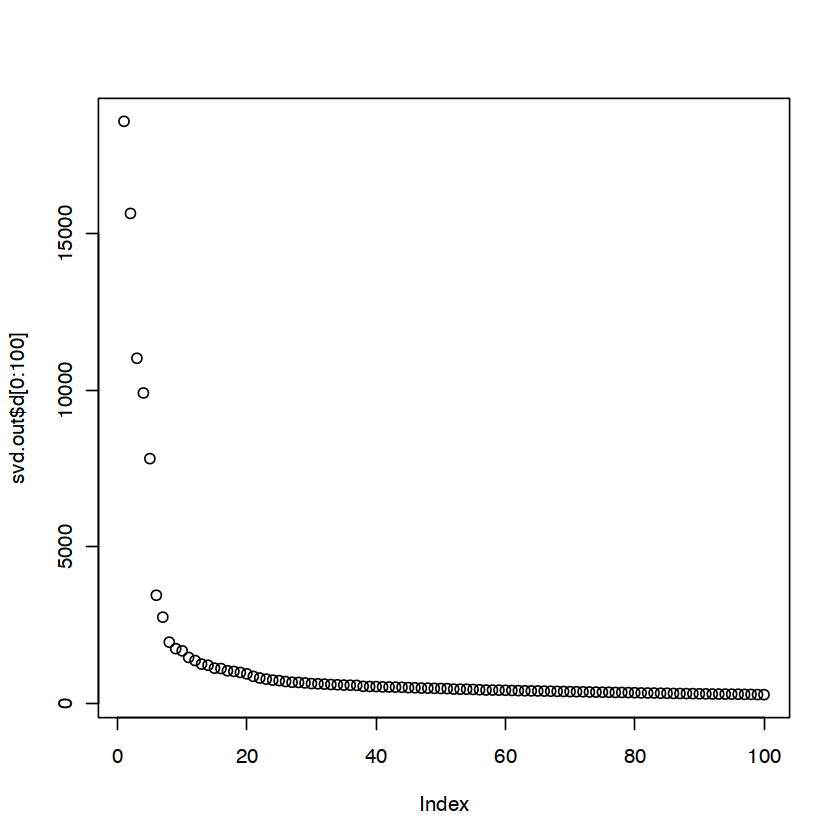

In [23]:
plot(svd.out$d[0:100])

In [61]:
var_from_d = svd.out$d^2

In [62]:
var_from_d[is.na(var_from_d)] <- 0

In [63]:
frac_var_from_d = var_from_d / sum(var_from_d)

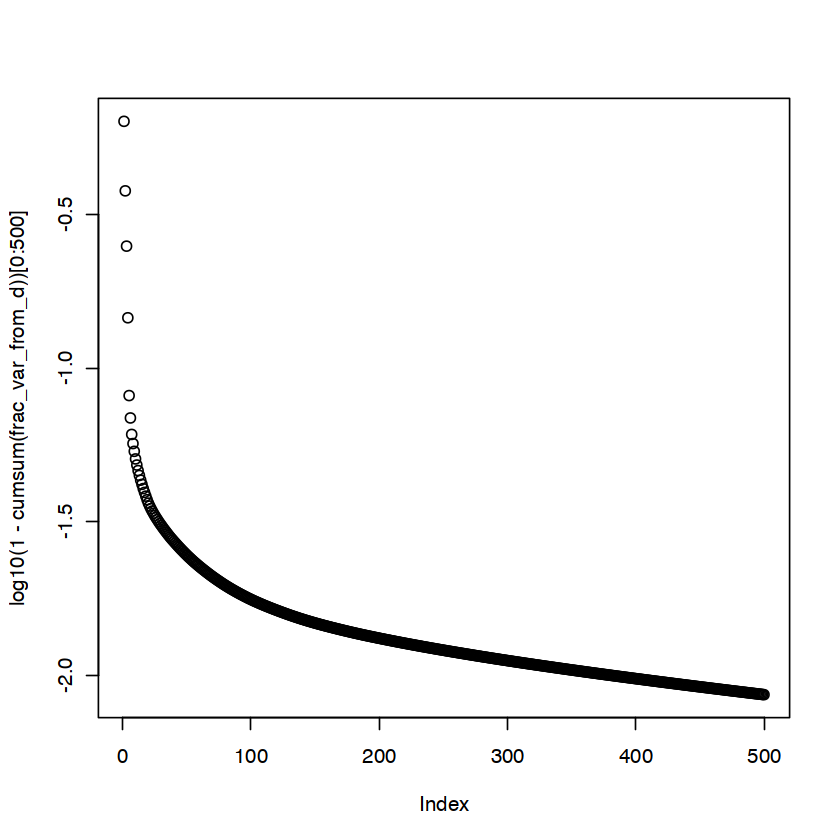

In [70]:
plot(log10(1 - cumsum(frac_var_from_d))[0:500])

In [165]:
climb_out = climb(sc.es, bulk.es, mode = 'abundance')

ABUNDANCE mode: predicting cell-type proportions in bulks

7955 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance / expression

Cell-type abundance prediction done. 



In [167]:
#climb_out = readRDS('data/expression_deconv/climb_out_vg2na_OE_n7to13_2.RDS')

In [168]:
bulk_pred = (exprs(sc.es) %*% num(climb_out$coefs[[1]]))

In [169]:
#bulk.es = readRDS('data/pseudobulks_climb/AML_naldini_pbulks_vg_labs.RDS')

In [172]:
mse = sum((exprs(bulk.es)[,1] - bulk_pred)^2)/length(bulk_pred)

In [175]:
mse / (sum(bulk_pred^2)/length(bulk_pred))

[1] 1.789939

In [45]:
mean(rowSums(do.call(rbind,climb_out$coefs) > 0))

[1] 554.3846

In [74]:
cov_mat = cov(exprs(sc.es))

In [122]:
sum(cov_mat[sc.es$cellType_original == ct, sc.es$cellType_original != ct] < 0)

[1] 14

In [145]:
dim(sc.es)

Features  Samples 
    7955    15255

In [131]:
celltypes = unique(sc.es$cellType_original)

min_cov_ct = list() ; inter_bloc = list() ; total_elements = list() ; neg_elements = list()
for(k in 1:length(celltypes)){
    ct = celltypes[k]
    min_cov_ct[[k]] = min(cov_mat[sc.es$cellType_original == ct, sc.es$cellType_original == ct])
    mat_inter_k = cov_mat[sc.es$cellType_original == ct, sc.es$cellType_original != ct]
    total_elements[[k]] = dim(mat_inter_k)[1]*dim(mat_inter_k)[2]
    inter_bloc[[k]] = sum(mat_inter_k < 0)
    neg_elements[[k]] = mat_inter_k[mat_inter_k < 0]
}
names(min_cov_ct) = celltypes
min_cov_ct

$GMP
[1] 0.02592354

$`GMP-like`
[1] 0.01821658

$`Prog-like`
[1] -0.1686945

$`ProMono-like`
[1] 0.04823409

$`HSC-like`
[1] 0.003701817

$`cDC-like`
[1] 0.01546114

$`Mono-like`
[1] 0.03142649

$Mono
[1] 0.03698751

$Prog
[1] 0.03975573

$cDC
[1] 0.05615839

$HSC
[1] 0.01481182

$ProMono
[1] 0.07318198

$earlyEry
[1] 0.01466811

$CTL
[1] 0.01791054

$T
[1] 0.02045751

$Plasma
[1] 0.04266888

$ProB
[1] 0.02745493

$NK
[1] 0.01272689

$lateEry
[1] 0.04027162

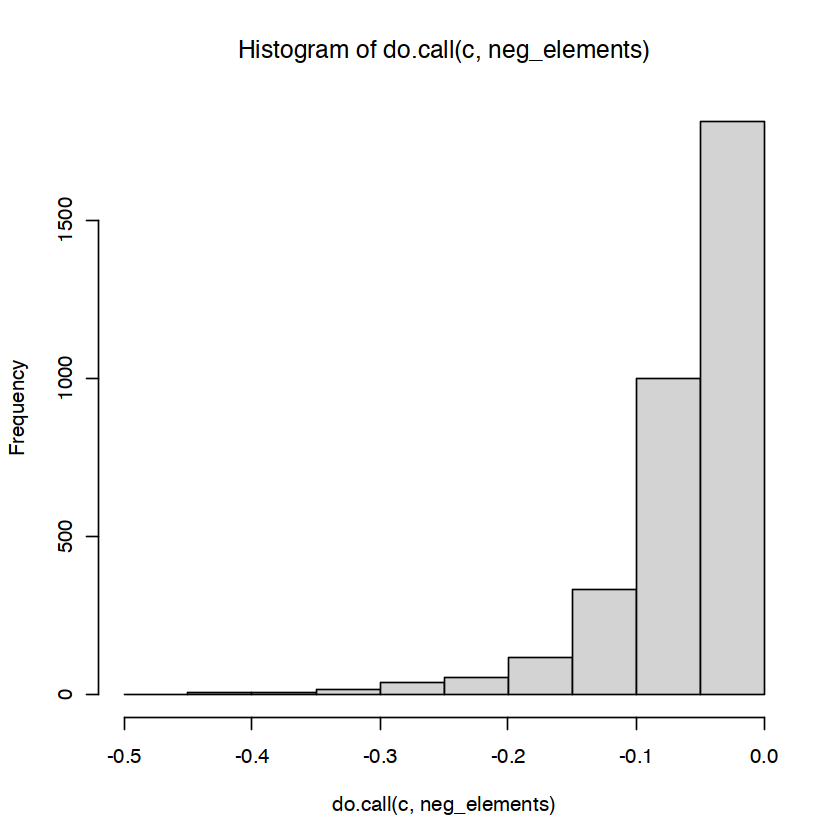

In [143]:
hist(do.call(c,neg_elements))

In [144]:
?hist

In [138]:
15000^2

[1] 2.25e+08

In [130]:
sum(num(inter_bloc))/sum(num(total_elements))

[1] 1.63251e-05

In [98]:
library(ComplexHeatmap) ; library(circlize)

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



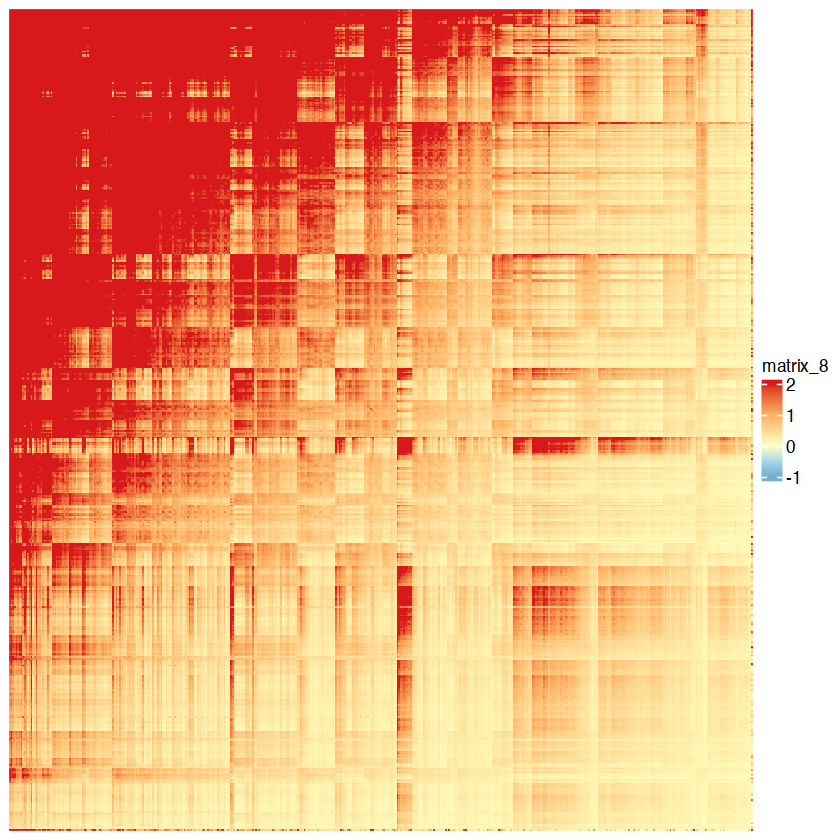

In [103]:
col_panel = c('#74add1', "#abd9e9", '#ffffbf','#fdae61', '#d7191c')
col_fun = colorRamp2(c(-1,-0.5,0,1,2), col_panel)
ct1 = 'HSC-like' ; ct2 = 'Mono-like'
Heatmap(cov_mat[sc.es$cellType_original == ct1 | sc.es$cellType_original == ct2,
                sc.es$cellType_original == ct1 | sc.es$cellType_original == ct2], col=col_fun,
        show_column_names=F, show_row_names=F, show_column_dend=F, show_row_dend=F)

In [104]:
cor_mat = cor(exprs(sc.es))

In [105]:
celltypes = unique(sc.es$cellType_original)

min_cor_ct = list()
for(k in 1:length(celltypes)){
    ct = celltypes[k]
    min_cor_ct[[k]] = min(cor_mat[sc.es$cellType_original == ct,sc.es$cellType_original == ct])
}
names(min_cor_ct) = celltypes
min_cor_ct

$GMP
[1] 0.06691626

$`GMP-like`
[1] 0.02506956

$`Prog-like`
[1] -0.0007838485

$`ProMono-like`
[1] 0.05341139

$`HSC-like`
[1] 0.003975662

$`cDC-like`
[1] 0.01989335

$`Mono-like`
[1] 0.00178674

$Mono
[1] 0.02688908

$Prog
[1] 0.07440904

$cDC
[1] 0.04475846

$HSC
[1] 0.009403902

$ProMono
[1] 0.1519242

$earlyEry
[1] 0.004649854

$CTL
[1] 0.007515196

$T
[1] 0.01265653

$Plasma
[1] 0.0101682

$ProB
[1] 0.04876473

$NK
[1] 0.004105074

$lateEry
[1] 0.003279663